In [66]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.modeling.loggers import Logger
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

In [67]:
class SineWaveDataset(Dataset):
    def __init__(self,freq_range,phase_range,num_timesteps,ts_dim,dataset_length) -> None:
        super().__init__()
        self.freq_range = freq_range
        self.phase_range = phase_range
        self.timestamps = np.arange(num_timesteps)
        self.ts_dim = ts_dim
        self.data_length = dataset_length


    def __sampleFromRange(self,range):
        rand = np.random.random()
        return range[0] + rand*(range[1] - range[0])

    def __generateSingleRandomSin(self):
        sampled_freq = self.__sampleFromRange(self.freq_range)
        sampled_phase = self.__sampleFromRange(self.phase_range)
        return np.sin(self.timestamps*sampled_freq + sampled_phase)
    

    def generateData(self):

        sines = []
        for _ in range(self.ts_dim):
            sines.append(self.__generateSingleRandomSin())
        
        sines = np.stack(sines,axis= 0)
        return sines.T
    
    def __getitem__(self, index):
        return self.generateData()


    def __len__(self):
        return self.data_length


In [186]:
class Generator(nn.Module):
    def __init__(self,random_vector_dim,lstm_hidden_dim, ts_embedding_dim, ts_output_dim):
        super().__init__()
        self.random_vector_dim = random_vector_dim
        self.ts_embedding_dim = ts_embedding_dim
        lstm_in_dim = ts_embedding_dim + random_vector_dim
        self.start_token = nn.Parameter(torch.zeros(ts_embedding_dim, dtype= torch.float32))
        self.lstm = nn.LSTM(input_size= lstm_in_dim, hidden_size= lstm_hidden_dim,batch_first= True,num_layers= 2)
        self.embedding_linear = nn.Sequential(nn.Linear(lstm_hidden_dim,lstm_hidden_dim//2),nn.ReLU(),nn.Linear(lstm_hidden_dim//2,ts_embedding_dim))
        self.output_linear = nn.Sequential(nn.Linear(ts_embedding_dim,ts_output_dim))

        

    def forward(self,batch_size,seq_len):
        random_tensor = torch.rand(batch_size,seq_len,self.random_vector_dim) # (BS,seq_len,random_vector_len)
        batch_start_token = torch.tile(input= self.start_token,dims= [batch_size,1]) #  (BS,ts_embedding_dim)
        lstm_input = torch.concatenate([batch_start_token,random_tensor[:,0,:]],dim= 1) # (BS,lstm_input_dim)
        lstm_output = torch.empty(size= (batch_size,seq_len,self.ts_embedding_dim),dtype= torch.float32)


        lstm_out, lstm_state = self.lstm(lstm_input.unsqueeze(1))
        lstm_out = self.embedding_linear(lstm_out[:,0,:])
        lstm_output[:,0,:] = lstm_out

        for i in range(1,seq_len):
            lstm_input = torch.concatenate([lstm_out,random_tensor[:,i,:]],dim = 1)
            
            lstm_out, lstm_state = self.lstm(lstm_input.unsqueeze(dim= 1),lstm_state)
            lstm_out = self.embedding_linear(lstm_out[:,0,:])
            lstm_output[:,i,:] = lstm_out
        
        generated_seq = self.output_linear(lstm_output)
        return generated_seq
    



        


class Discriminator(nn.Module):
    def __init__(self,ts_dim,ts_embedding_dim,lstm_hidden_dim) -> None:
        super().__init__()
        
        self.ts_to_embedding_linear = nn.Sequential(nn.Linear(ts_dim,ts_dim*2), nn.Linear(ts_dim*2,ts_embedding_dim))
        self.lstm = nn.LSTM(input_size= ts_embedding_dim,hidden_size= lstm_hidden_dim,num_layers= 2, bidirectional= False,batch_first= True)
        self.prediction_linear = nn.Sequential(nn.Linear(lstm_hidden_dim,lstm_hidden_dim//2), nn.Linear(lstm_hidden_dim//2,1), nn.Sigmoid())
        
    def forward(self,X):

        X = self.ts_to_embedding_linear(X)
        X,_ = self.lstm(X)
        preds = self.prediction_linear(X[:,-1,:])
        return preds
    


class TransformerGenerator(nn.Module):
    def __init__(self,ts_dim,embedding_dim,num_layers,num_heads,max_seq_len = 100) -> None:
        super().__init__()

        self.positional_encodings = nn.Embedding(max_seq_len,embedding_dim)
        self.ts_dim_to_embedding_dim_linear = nn.Linear(ts_dim,embedding_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first= True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.embedding_dim_to_ts_dim_linear = nn.Linear(embedding_dim,ts_dim)

    

    def forward(self,z):

        batch_size,seq_len ,input_dim = z.size()
        positions = torch.arange(0, seq_len).unsqueeze(0).expand([batch_size,-1])

        x = self.ts_dim_to_embedding_dim_linear(z) + self.positional_encodings(positions)
        x = self.transformer_encoder(x)
        x = self.embedding_dim_to_ts_dim_linear(x)
        return x

        


In [187]:
class GANTrainer:
    def __init__(self,generator : Generator,discriminator : Discriminator,train_dataset : SineWaveDataset,logger : Logger):
        self.generator = generator
        self.discriminator = discriminator
        self.logger = logger   
        self.train_dataset = train_dataset

    
    def trainStep(self,real_batch,generator_optimizer,discriminator_optimizer):
        # real batch of shape (BS,seq_len,features)
        fake_batch = self.generator(torch.rand_like(real_batch))

        real_batch_model_out = self.discriminator(real_batch)
        fake_batch_model_out = self.discriminator(fake_batch.detach())

        real_batch_loss_discriminator = -(real_batch_model_out.mean())
        fake_batch_loss_discriminator = fake_batch_model_out.mean()

        discriminator_loss = real_batch_loss_discriminator + fake_batch_loss_discriminator

        discriminator_loss.backward()
        discriminator_optimizer.step()

        # this time without detach
        fake_batch_model_out = self.discriminator(fake_batch)
        generator_loss = -(fake_batch_model_out.mean())
        generator_loss.backward()
        generator_optimizer.step()
 

        return discriminator_loss,generator_loss


    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)


        # Calculate probability of interpolated examples
        prob_interpolated = self.discriminator(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def plotGeneratedSample(self):
        with torch.no_grad():
            generated = self.generator(torch.rand(1,25,1))[0].numpy()
            plt.plot(generated[:,0])
            plt.show()



    def train(self,epochs,batch_size,lr = .001):
        train_dataloader = DataLoader(dataset= self.train_dataset,batch_size= batch_size,drop_last= True,shuffle= True)
        generator_optimizer = torch.optim.Adam(params= self.generator.parameters(), lr= lr)
        discriminator_optimizer = torch.optim.Adam(params= self.discriminator.parameters(), lr= lr)


        for epoch in range(epochs):
            gen_epoch_loss, dis_epoch_loss = 0,0
            counter = 0
            for batch in train_dataloader:
                discriminator_optimizer.zero_grad()
                generator_optimizer.zero_grad()

                discriminator_loss, generator_loss = self.trainStep(real_batch= batch.float(),generator_optimizer= generator_optimizer, discriminator_optimizer= discriminator_optimizer)

                gen_epoch_loss += generator_loss.item()
                dis_epoch_loss += discriminator_loss.item()
                counter += 1
            

            self.logger.addMetric(metric_name= "generator_epoch_loss", value= gen_epoch_loss/counter)
            self.logger.addMetric(metric_name= "discriminator_epoch_loss", value= dis_epoch_loss/counter)

            if epoch%5 == 0:
                self.plotGeneratedSample()








In [188]:
train_dataset = SineWaveDataset(freq_range= (.2,1), phase_range= (.2,.1), num_timesteps= 25,dataset_length= 5000,ts_dim= 1)
logger = Logger()

In [190]:
generator = TransformerGenerator(ts_dim= 1,embedding_dim= 64,num_heads= 4, num_layers= 4)#Generator(random_vector_dim= 16,lstm_hidden_dim= 64,ts_embedding_dim= 32, ts_output_dim= 1)
discriminator = Discriminator(ts_dim= 1,ts_embedding_dim= 16,lstm_hidden_dim= 16)

In [120]:
# (32,25,1) real and fake data
real_data = torch.rand(32,25,1)
generated_data = torch.rand(32,25,1)
alpha = torch.rand(32, 1, 1)
alpha = alpha.expand_as(real_data)

interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
interpolated = Variable(interpolated, requires_grad=True)
prob_interpolated = discriminator(interpolated)

In [126]:
prob_interpolated[1]

tensor(0.4473, grad_fn=<SelectBackward0>)

In [122]:
gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

In [191]:
trainer = GANTrainer(generator= generator,discriminator= discriminator,train_dataset= train_dataset,logger= logger)

1 metric generator_epoch_loss = -0.4355765034755071
1 metric discriminator_epoch_loss = 0.00047790010770161945


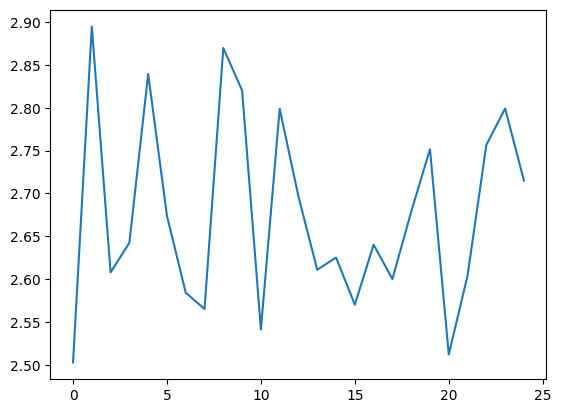

2 metric generator_epoch_loss = -0.4587224867099371
2 metric discriminator_epoch_loss = -3.3379747317387504e-05
3 metric generator_epoch_loss = -0.45193117551314527
3 metric discriminator_epoch_loss = 5.830633334624462e-05
4 metric generator_epoch_loss = -0.4174620110828143
4 metric discriminator_epoch_loss = -0.10984092530531761
5 metric generator_epoch_loss = -0.010482757271697314
5 metric discriminator_epoch_loss = -0.9728465263660138
6 metric generator_epoch_loss = -0.0008259294278477916
6 metric discriminator_epoch_loss = -0.997829896517289


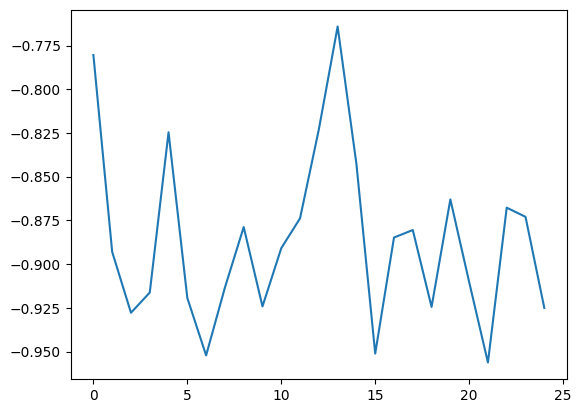

KeyboardInterrupt: 

In [192]:
trainer.train(epochs= 500,batch_size= 64, lr = .001)

In [193]:
loader = DataLoader(train_dataset,batch_size = 10)

In [194]:
for i in loader:
    break

In [199]:
discriminator(torch.rand(10,8,1))

tensor([[0.0792],
        [0.0570],
        [0.0217],
        [0.0261],
        [0.1659],
        [0.0275],
        [0.5036],
        [0.2468],
        [0.3579],
        [0.0246]], grad_fn=<SigmoidBackward0>)

In [200]:
discriminator(i.float())

tensor([[0.9993],
        [0.9993],
        [0.9992],
        [0.9992],
        [0.9993],
        [0.9992],
        [0.9993],
        [0.9993],
        [0.9992],
        [0.9992]], grad_fn=<SigmoidBackward0>)